<a href="https://colab.research.google.com/github/IreneLedyaeva/CAP-5610/blob/master/HW3/problem_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing heatmaps of class activations

### Loading the convolutional base of VGG19

In [0]:
from keras.applications import VGG19

model = VGG19(weights='imagenet') 

574717952/574710816 [==============================] - 35s 0us/step


### Uploading the model obtained in problem 2

In [0]:
from google.colab import files

uploaded = files.upload()

Saving cats_and_dogs_pretrained.h5 to cats_and_dogs_pretrained.h5


### Uploading the images of cats and dogs

In [0]:
!wget https://cdn.royalcanin-weshare-online.io/d_o7IGYBIYfdNSoC2wgt/v1/bd29h-basset-hound-adult-in-black-and-white?raw=true -O basset_hound.jpg

!wget https://i.imgur.com/3qMPlcg.png?raw=true -O maine_coon.jpg
  
img_path1 = 'basset_hound.jpg'
img_path2 = 'maine_coon.jpg'

--2019-04-14 21:09:02--  https://cdn.royalcanin-weshare-online.io/d_o7IGYBIYfdNSoC2wgt/v1/bd29h-basset-hound-adult-in-black-and-white?raw=true
Resolving cdn.royalcanin-weshare-online.io (cdn.royalcanin-weshare-online.io)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to cdn.royalcanin-weshare-online.io (cdn.royalcanin-weshare-online.io)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/png]
Saving to: ‘basset_hound.jpg’

basset_hound.jpg        [  <=>               ]   2.43M  7.92MB/s    in 0.3s    

2019-04-14 21:09:03 (7.92 MB/s) - ‘basset_hound.jpg’ saved [2544249]

--2019-04-14 21:09:03--  https://i.imgur.com/3qMPlcg.png?raw=true
Resolving i.imgur.com (i.imgur.com)... 151.101.52.193
Connecting to i.imgur.com (i.imgur.com)|151.101.52.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2023584 (1.9M) [image/png]
Saving to: ‘maine_coon.jpg’

maine_coon.jpg      100%[==================

### Getting the last convolutional layer

In [0]:
from keras.models import load_model

model.summary()
last_conv_layer = model.get_layer('block5_conv4')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Resizing the heatmap and processing the image

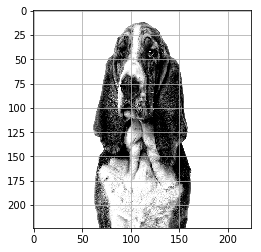

Predicted: [('n02088466', 'bloodhound', 0.61681145), ('n02088238', 'basset', 0.36864665)]


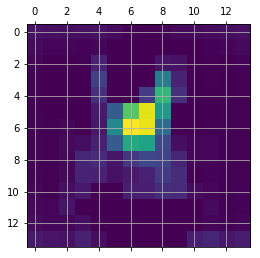

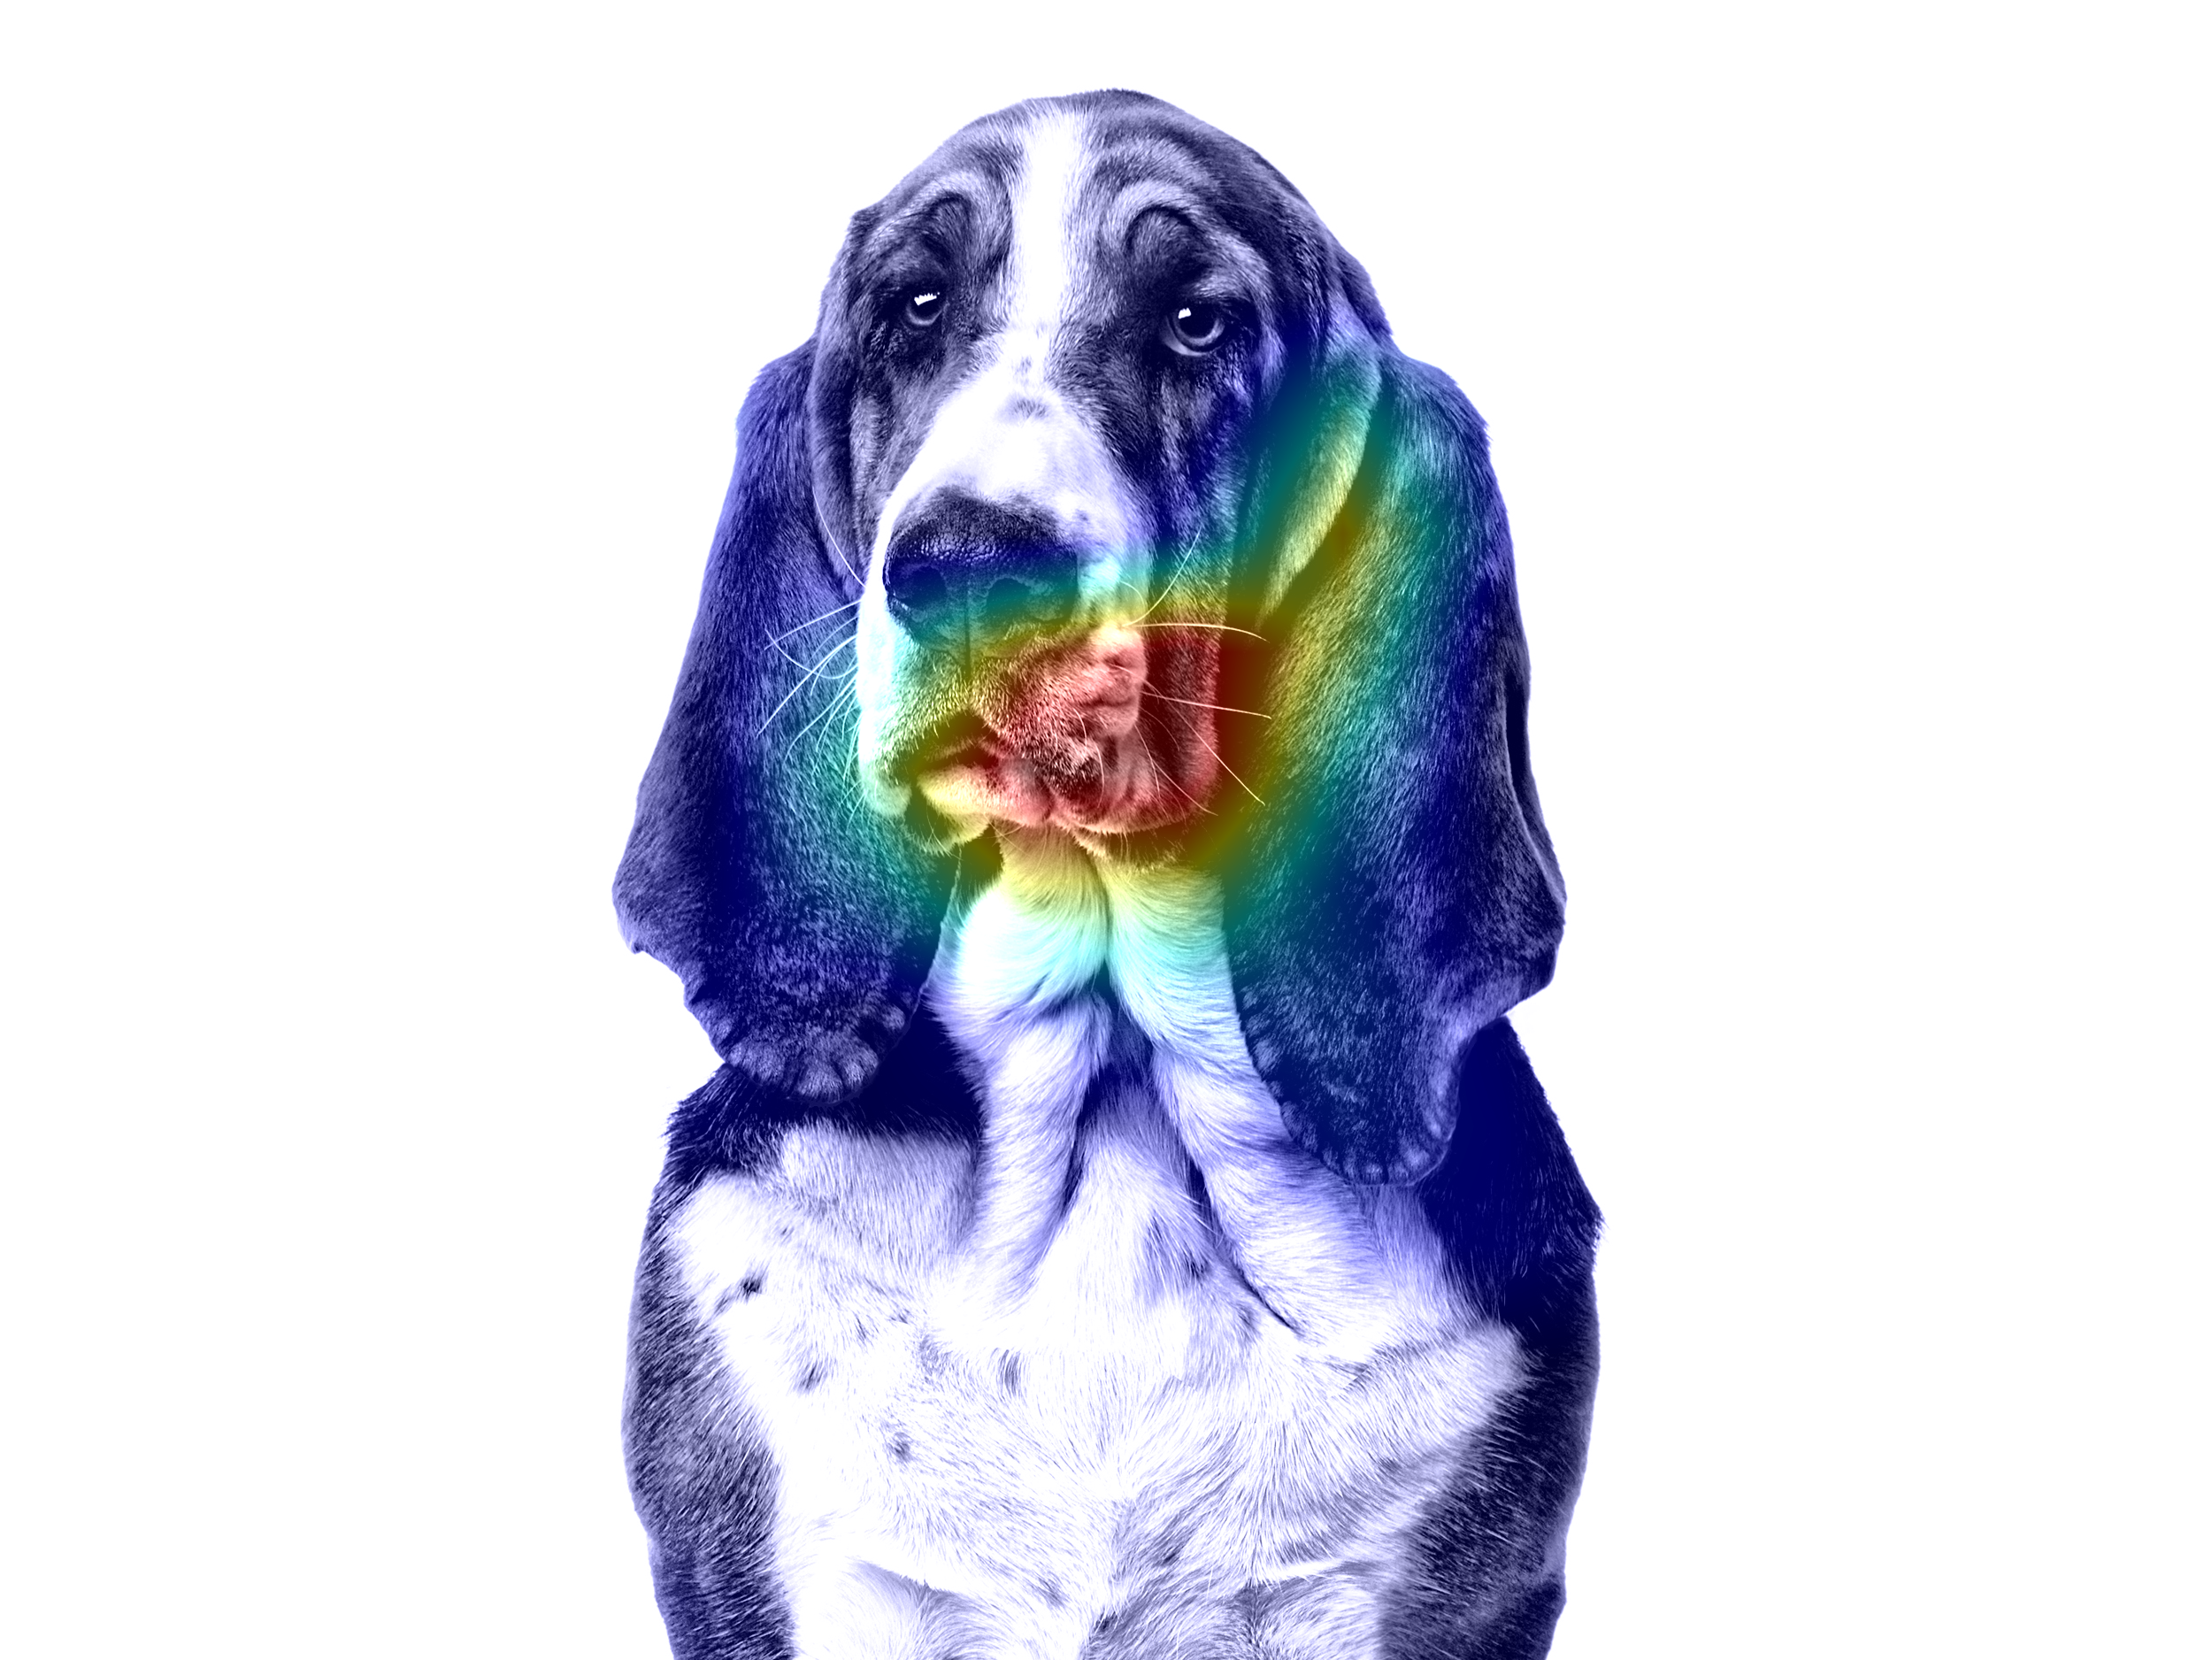

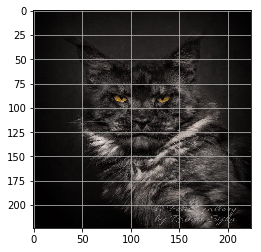

Predicted: [('n02127052', 'lynx', 0.5423504), ('n02123394', 'Persian_cat', 0.37814742)]


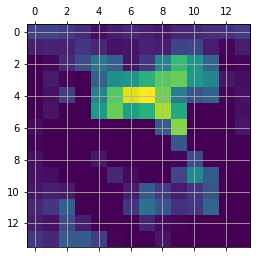

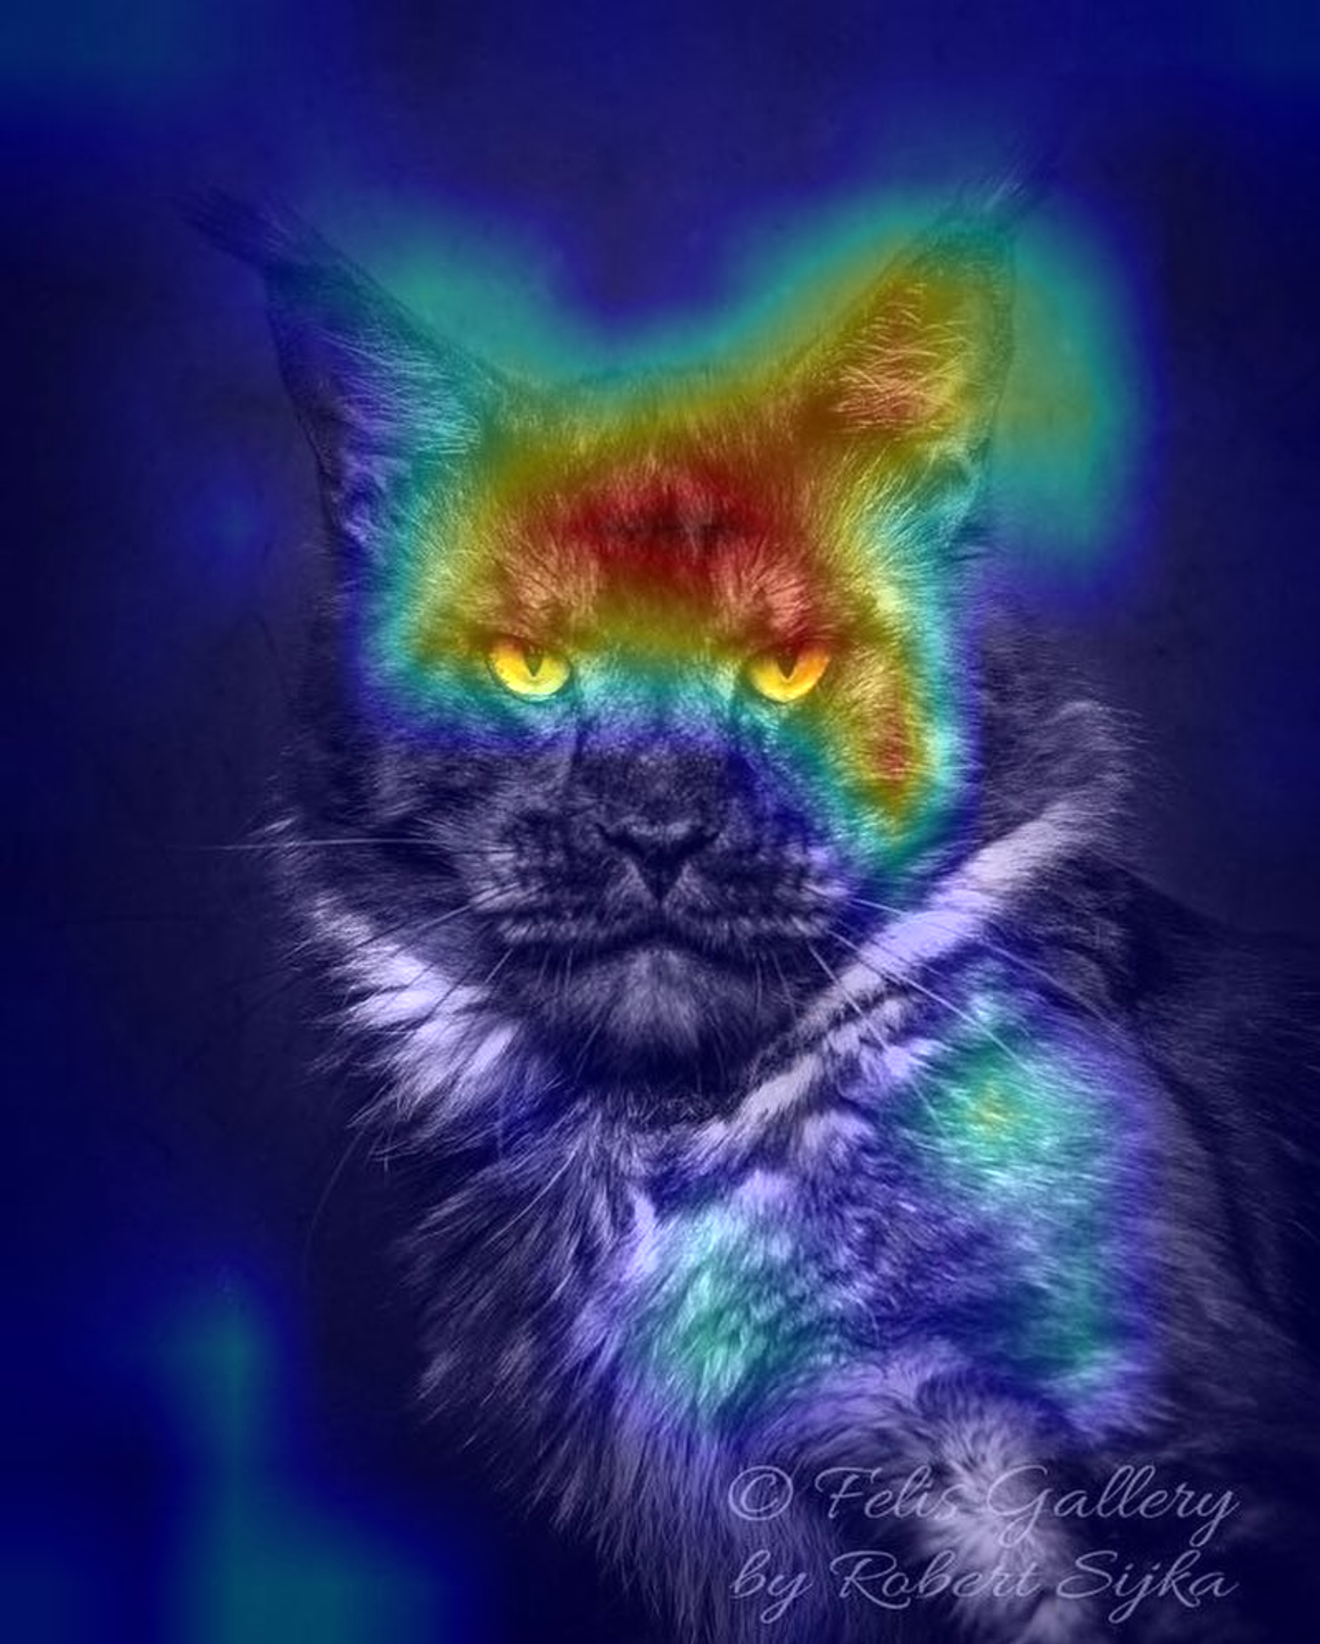

In [0]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K

def show_superimposed_image(img_path, heatmap):

  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2_imshow(superimposed_img)
  
def process_image(img_path, idx=0):
  
  img = image.load_img(img_path, target_size=(224, 224))
  
  plt.imshow(img)
  plt.grid(None)
  plt.show()
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  preds = model.predict(x)
  print('Predicted:', decode_predictions(preds, top=2)[0])
  
  class_index = np.argsort(preds[0])[-(1+idx)]
  class_output = model.output[:, class_index]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  
  show_superimposed_image(img_path, heatmap)

process_image(img_path1)
process_image(img_path2)